In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from  torch.utils import data
import matplotlib.pyplot as plt

In [35]:
dataset = torchvision.datasets.FashionMNIST(root='fashionmnist/', train=True, download=True,
                                     transform=torchvision.transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 26421880/26421880 [00:28<00:00, 932876.49it/s] 


Extracting fashionmnist/FashionMNIST\raw\train-images-idx3-ubyte.gz to fashionmnist/FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 313129.69it/s]


Extracting fashionmnist/FashionMNIST\raw\train-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:05<00:00, 753231.80it/s]


Extracting fashionmnist/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fashionmnist/FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting fashionmnist/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fashionmnist/FashionMNIST\raw



In [53]:
# first i coded the double conv as it represented in the original unet paper
class DBConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        # we use silu activation function
        self.conv_layer = nn.Sequential(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
                                        nn.SiLU(),
                                        nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
                                        nn.SiLU())
    def forward(self,x):
        
        return self.conv_layer(x)
class Unet(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unet,self).__init__()
        self.max_pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        self.down_conv1 = DBConv(in_channels=in_channels,out_channels=32)
        self.down_conv2 = DBConv(in_channels=32,out_channels=64)
        self.down_conv3 = DBConv(in_channels=64,out_channels=64)
        self.layers = nn.ModuleList([self.down_conv1,self.down_conv2,self.down_conv3])
        self.up_conv1 = DBConv(in_channels=64,out_channels=64)
        self.trans_conv2 = nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=2,stride=2)
        self.up_conv2 = DBConv(in_channels=64,out_channels=32)
        self.trans_conv3 = nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=2,stride=2)
        self.up_conv3 = DBConv(in_channels=32,out_channels=out_channels)
        self.up_layers = nn.ModuleList([self.up_conv1,self.trans_conv2,self.up_conv2,self.trans_conv3,self.up_conv3])
    def forward(self, x):
        residual = []
        for i,layer  in enumerate(self.layers):
            x = layer(x)
            if i < 2:
                # store the output of the first and second layer to use them in the upsample part of the unet
                residual.append(x)
                x = self.max_pool2(x)
                
        for i , layer in enumerate(self.up_layers):
            x = layer(x)
            if i % 2 != 0 :
                # if the layer is double conv we do not add the residual , we add just after the upsampling
                x += residual.pop()
        return x
            
class Simplediff(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.Unet = Unet(in_channels,out_channels)
    def forward(self,x):
        x = self.Unet(x)
        return x
    def corrupt(self,x,noisy_amount):
        # reshape the noise_amount to broadcast it across the height and width dims
        noisy_amount = noisy_amount.view(-1,1,1,1)
        noise = torch.rand_like(x)
        # simple way of noising an image
        return (1 - noisy_amount) * x + noisy_amount * noise
    def sample(self,n_steps):
        self.n_steps = n_steps
        # save the predictions in list and the real images that we pass as input to model in other list
        self.pred_story = []
        self.real_img_story = []
        # be carefully with the shapes , if you use dataset different from mnist size , you must change tensor shape of random noise 
        x = torch.rand(5,1,28,28).to(device)
        mix_steps = 1 / ( n_steps- 1 )
        for i in range(n_steps):
            with torch.no_grad():
                pred = self(x)
            self.pred_story.append(pred.detach().cpu())
            # simple way of denoising process
            x = (1 - mix_steps) * pred + mix_steps * pred
            self.real_img_story.append(x.detach().cpu())
        return self.real_img_story , self.pred_story
    def visualize(self):
        # visualization
        fig, axes = plt.subplots(self.n_steps,2,figsize=(12,7))
        axes[0,0].set_title('prediction images')
        axes[0,1].set_title('x (model input)')
        for i in range(self.n_steps):
            axes[i,0].imshow(torchvision.utils.make_grid(self.pred_story[i])[0].clip(0,1),cmap='Greys')
            axes[i,1].imshow(torchvision.utils.make_grid(self.real_img_story[i])[0].clip(0,1),cmap='Greys')
        

In [54]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def training_loop(epochs):
    model = Simplediff(1,1).to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr=1e-4)
    losses = []
    for epoch in range(epochs):
        for x , y  in train_loader:
            optimizer.zero_grad()
            x  = x.to(device)
            noisy_amount = torch.rand(x.shape[0]).to(device)
            noisy_x = model.corrupt(x,noisy_amount)
            pred = model(noisy_x)
            loss = loss_fn(x,pred)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        avg_loss = sum(losses[-len(train_loader):])/len(train_loader)
        print(f'epoch {epoch} | Avg loss {avg_loss}')
    plt.plot(losses)
    plt.ylim(0,0.2)
    return model

epoch 0 | Avg loss 0.06754403845714863
epoch 1 | Avg loss 0.03771831762434831
epoch 2 | Avg loss 0.030433951124453594
epoch 3 | Avg loss 0.02761683319963372
epoch 4 | Avg loss 0.02600837353942618
epoch 5 | Avg loss 0.025154104531764476
epoch 6 | Avg loss 0.024351690723094097
epoch 7 | Avg loss 0.02349036161118606
epoch 8 | Avg loss 0.02327158425583133
epoch 9 | Avg loss 0.02288527385210559


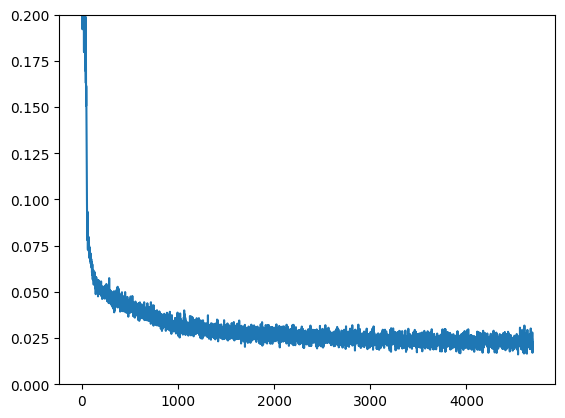

In [55]:
net = training_loop(10)

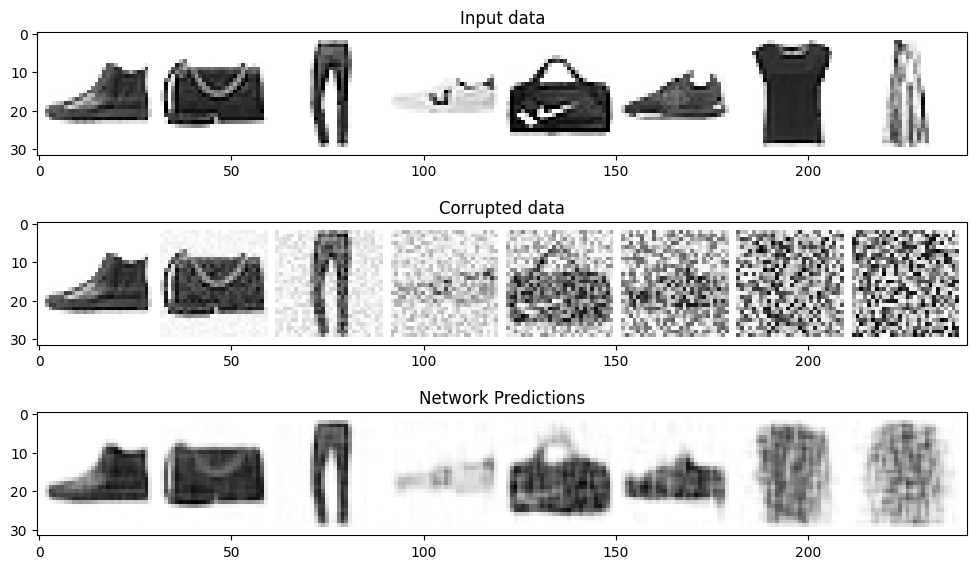

In [56]:
x, y = next(iter(train_loader))
x = x[:8] # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0]) # Left to right -> more corruption
noised_x = net.corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
  preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title('Input data')
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1),cmap='Greys')
axs[1].set_title('Corrupted data')
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1),cmap='Greys')
axs[2].set_title('Network Predictions')
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1),cmap='Greys')

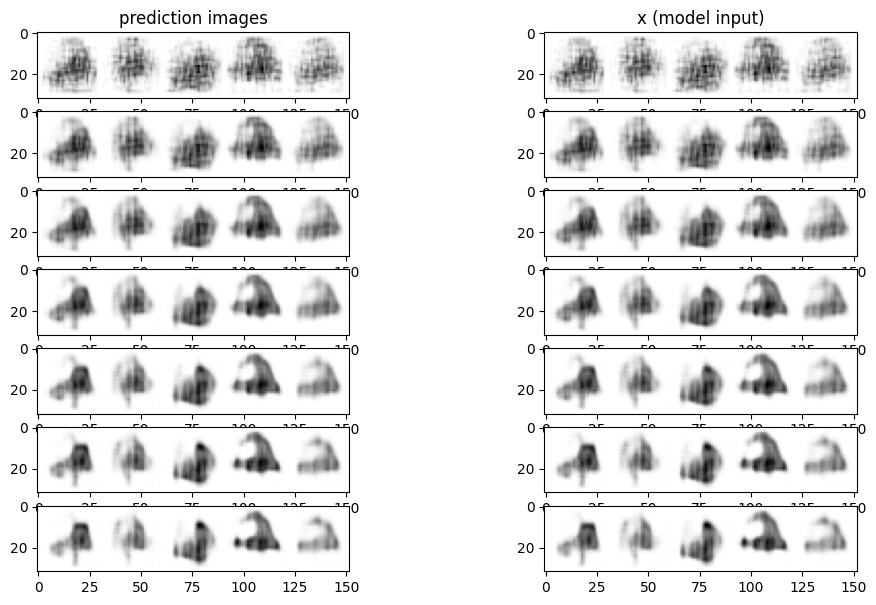

In [57]:
a,b = net.sample(7)
net.visualize()